<a href="https://colab.research.google.com/github/Romuald2014/WATERFALL-PROJECT/blob/main/Waterfall_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Waterfall Analysis of Sales Forecast Changes

### Introduction
- Objective: To investigate changes in forecast sales using a waterfall model.
- Dataset: Sales data with various stages and amounts.

### Data Loading and Initial Exploration
- **Load Data:**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'deal_history.csv'
deal_history = pd.read_csv(file_path)

### Data Preparation

- **Data Type Conversion:**

In [2]:
# Convert 'changed_at', 'closing_date' and 'created_date' to datetime
deal_history['changed_at'] = pd.to_datetime(deal_history['changed_at'], format='%d/%m/%Y')
deal_history['closing_date'] = pd.to_datetime(deal_history['closing_date'], format='%d/%m/%Y')
deal_history['created_date'] = pd.to_datetime(deal_history['created_date'], format='%d/%m/%Y')

### Creating Necessary Functions And Variables

In [3]:
def fetch_latest_deals_prior_to_date(history_df, reference_date):
    """
    This function filters the deal history to retain only the most recent deal for each deal_id before the specified
    reference date and with a closing_date within a 3-month window following the reference date.
    """

    # Sort the dataframe by 'deal_id' and 'changed_at'
    sorted_history = history_df.sort_values(by=['deal_id', 'changed_at'])

    # Retain only the last deal before the reference date for each deal_id
    latest_deals_prior_date = sorted_history[sorted_history['changed_at'] <= reference_date].drop_duplicates(subset=['deal_id'], keep='last')

    # Filter deals with closing_date within 3 months after the reference date
    three_months_later = reference_date + pd.DateOffset(months=3)
    valid_deals = latest_deals_prior_date[(latest_deals_prior_date['closing_date'] >= reference_date) &
                                          (latest_deals_prior_date['closing_date'] <= three_months_later)]

    return valid_deals


def refresh_deal_attributes(output_deals, history, cutoff_date):
    """
    This function refreshes the stage, closing_date, and changed_at attributes of deals in output_deals based on the
    most recent information from the history DataFrame before the specified cutoff_date.

    Parameters:
    output_deals (DataFrame): DataFrame containing deals that are in the initial pipeline but not in the final pipeline.
    history (DataFrame): DataFrame containing the comprehensive history of deals.
    cutoff_date (str): The cutoff date to filter the deal history by in 'YYYY-MM-DD' format.

    Returns:
    DataFrame: Updated output_deals DataFrame with attributes from the history.
    """

    # Filter history to get the latest updates before the cutoff_date for each deal_id
    recent_updates = history[history['changed_at'] <= cutoff_date].sort_values(by=['deal_id', 'changed_at'])
    recent_updates = recent_updates.drop_duplicates(subset=['deal_id'], keep='last')

    # Merge output_deals with recent_updates to get updated attributes
    updated_output = output_deals.merge(recent_updates[['deal_id', 'stage', 'closing_date', 'changed_at']],
                                        on='deal_id',
                                        suffixes=('_initial', '_latest'),
                                        how='left')

    # Update the attributes with the values from the recent_updates
    updated_output['stage'] = updated_output['stage_latest'].combine_first(updated_output['stage_initial'])
    updated_output['closing_date'] = updated_output['closing_date_latest'].combine_first(updated_output['closing_date_initial'])
    updated_output['changed_at'] = updated_output['changed_at_latest'].combine_first(updated_output['changed_at_initial'])

    # Drop the temporary columns used for merging
    updated_output.drop(columns=['stage_initial', 'stage_latest', 'closing_date_initial', 'closing_date_latest', 'changed_at_initial', 'changed_at_latest'], inplace=True)

    return updated_output


# Function to format numbers as USD currency
def format_usd_currency(value):
    """Format number as currency with USD sign"""
    return f"${value:,.0f}"

# List of stages that are deemed inactive
inactive_stages = ['Closed Won', 'Closed Lost']

### Analysis and Сharting
- **Defining Start and End Pipeline Dates:**

In [4]:
# Define Start Pipeline and End Pipeline Dates
start_date = pd.to_datetime("2024-05-05")
end_date = pd.to_datetime("2024-05-20")

- **Identifying Deal Categories and Calculating Sum:**

In [5]:
# Fetch pipelines
initial_pipeline = fetch_latest_deals_prior_to_date(deal_history, start_date)
final_pipeline = fetch_latest_deals_prior_to_date(deal_history, end_date)

# Exclude deals from initial_pipeline based on inactive_stages
initial_pipeline = initial_pipeline[~initial_pipeline['stage'].isin(inactive_stages)]

# Identify and categorize deals entering the pipeline
deals_in_pipeline = final_pipeline[~final_pipeline['deal_id'].isin(initial_pipeline['deal_id'])]

# Split deals_in_pipeline based on their origin
new_deals = deals_in_pipeline[(deals_in_pipeline['created_date'] >= start_date) & (deals_in_pipeline['created_date'] <= end_date)]
pulled_deals = deals_in_pipeline[~deals_in_pipeline['deal_id'].isin(new_deals['deal_id'])]

# Identify deals exiting the pipeline
deals_exiting = initial_pipeline[~initial_pipeline['deal_id'].isin(final_pipeline['deal_id'])]

# Update deals_exiting with values as of the end_date
deals_exiting = refresh_deal_attributes(deals_exiting, deal_history, end_date)

# Identify won deals from deals_exiting
exited_deals_won = deals_exiting[deals_exiting['stage'] == 'Closed Won']

# Identify lost deals from deals_exiting
exited_deals_lost = deals_exiting[deals_exiting['stage'] == 'Closed Lost']

# Identify remaining deals as pushed out
pushed_out_deals = deals_exiting[~deals_exiting['deal_id'].isin(exited_deals_won['deal_id']) &
                                  ~deals_exiting['deal_id'].isin(exited_deals_lost['deal_id'])]

# Identify deals with increased amounts
increased_deals = initial_pipeline.merge(
    final_pipeline[['deal_id', 'amount']],
    on='deal_id',
    how='inner',
    suffixes=('_initial', '_final')
).loc[lambda x: x['amount_final'] > x['amount_initial']]

# Identify deals with decreased amounts
decreased_deals = initial_pipeline.merge(
    final_pipeline[['deal_id', 'amount']],
    on='deal_id',
    how='inner',
    suffixes=('_initial', '_final')
).loc[lambda x: x['amount_final'] < x['amount_initial']]

# Identify deals in final_pipeline with stage "Closed Won" and move them to exited_deals_won
final_pipeline_won = final_pipeline[final_pipeline['stage'] == 'Closed Won']

# Identify deals in final_pipeline with stage "Closed Lost" and move them to exited_deals_lost
final_pipeline_lost = final_pipeline[final_pipeline['stage'] == 'Closed Lost']

# Concatenate deals won
all_deals_won = pd.concat([exited_deals_won, final_pipeline_won], ignore_index=True)

# Concatenate deals lost
all_deals_lost = pd.concat([exited_deals_lost, final_pipeline_lost], ignore_index=True)

# Remove these deals from final_pipeline
final_pipeline = final_pipeline[~final_pipeline['deal_id'].isin(pd.concat([all_deals_won, all_deals_lost])['deal_id'])]

# Calculate the sums of amounts for the waterfall chart
initial_pipeline_sum = initial_pipeline['amount'].sum()
new_deals_sum = new_deals['amount'].sum()
pulled_deals_sum = pulled_deals['amount'].sum()
all_deals_won_sum = -all_deals_won['amount'].sum()
all_deals_lost_sum = -all_deals_lost['amount'].sum()
pushed_out_deals_sum = -pushed_out_deals['amount'].sum()
increased_deals_sum = increased_deals['amount_final'].sum() - increased_deals['amount_initial'].sum()
decreased_deals_sum = -decreased_deals['amount_initial'].sum() + decreased_deals['amount_final'].sum()
final_pipeline_sum = final_pipeline['amount'].sum()

- **Drawing Waterfall Chart:**

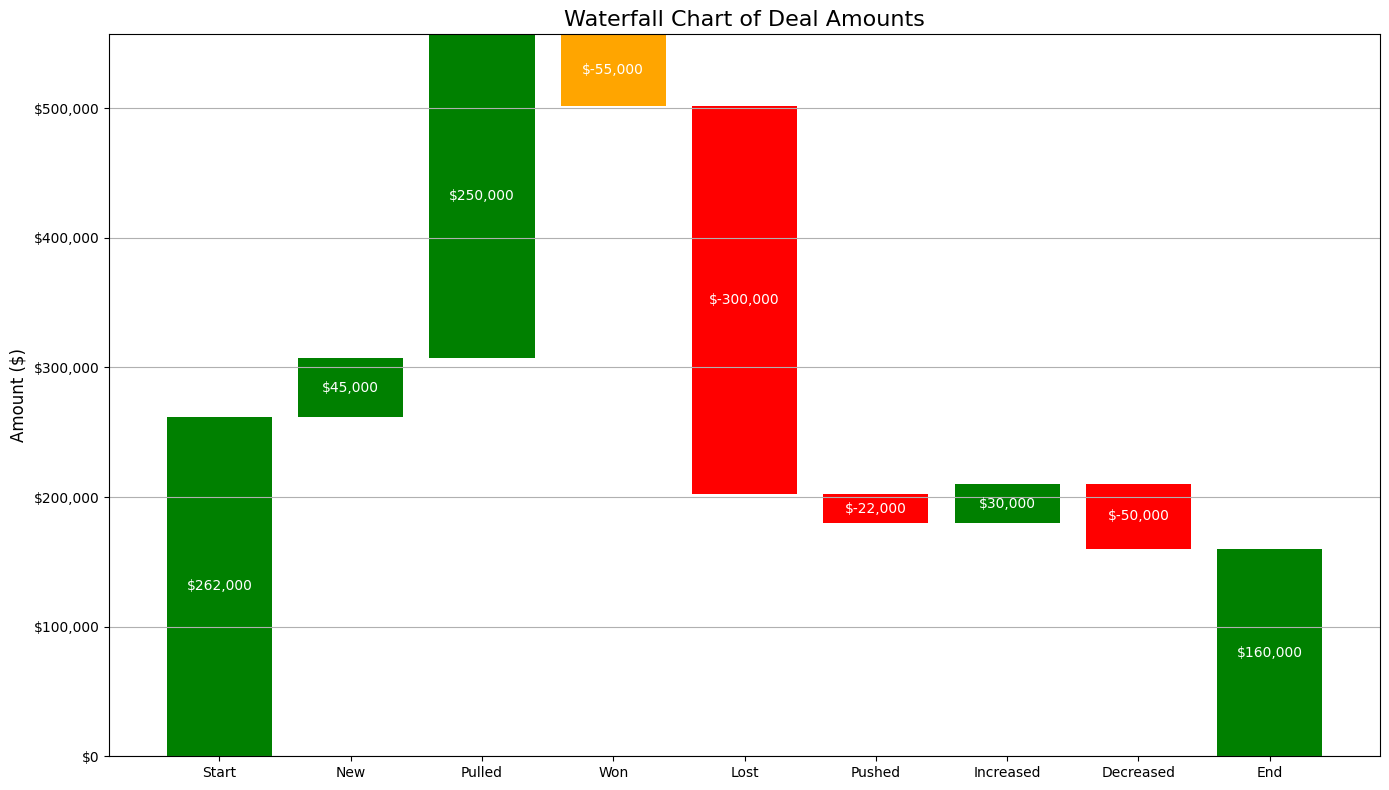

In [6]:
# Adjust waterfall values and labels to include the new categories
waterfall_values = [
    initial_pipeline_sum,
    new_deals_sum,
    pulled_deals_sum,
    all_deals_won_sum,
    all_deals_lost_sum,
    pushed_out_deals_sum,
    increased_deals_sum,
    decreased_deals_sum,
    final_pipeline_sum
]
cumulative = [0] + [sum(waterfall_values[:i+1]) for i in range(len(waterfall_values)-1)]
cumulative[-1] = 0  # Set the base of the last bar to 0

# Update labels
labels = ['Start', 'New', 'Pulled', 'Won', 'Lost', 'Pushed', 'Increased', 'Decreased', 'End']

# Create the waterfall chart with adjusted positions and formatted numbers
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(labels, waterfall_values, bottom=cumulative, align='center', color=['green', 'green', 'green', 'orange', 'red', 'red', 'green', 'red', 'green'])

# Displaying values on bars
for i, bar in enumerate(bars):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, cumulative[i] + yval/2, format_usd_currency(yval), ha='center', va='center', fontsize=10, color='white')

# Setting the title, labels, and tick formatting
ax.set_title('Waterfall Chart of Deal Amounts', fontsize=16)
ax.set_ylabel('Amount ($)', fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: format_usd_currency(x)))
ax.grid(axis='y')

# Display the chart
plt.tight_layout()
plt.show()